In [1]:
import sys
#sys.path.append("/mnt/AI/wgs-database/phenotype_extractors/PhenoBERT/phenobert/utils")
from api import *

In [2]:
# 方案1: 批次處理 + 進度條
import pandas as pd
from tqdm.notebook import tqdm
from io import StringIO
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import time


# 啟用 tqdm 對 pandas 的支持
tqdm.pandas()

def phenobert_predict_optimized(description):
    """優化後的單筆預測函數"""
    try:
        data_string = annotate_text(description)
        if not data_string.strip():  # 如果沒有結果
            return ""
        
        df = pd.read_csv(StringIO(data_string), sep='\t', header=None, 
                        names=['start', 'end', 'description', 'hpo_id', 'score', 'note'])
        df = df.sort_values(by='description')
        return ','.join(list(df.hpo_id))
    except Exception as e:
        print(f"Error processing description: {e}")
        return ""

def batch_phenobert_predict(descriptions, batch_size=10, max_workers=10):
    """
    批次處理版本 - 降低模型重新載入的開銷
    """
    results = []
    
    # 分批處理
    for i in tqdm(range(0, len(descriptions), batch_size), desc="Processing batches"):
        batch = descriptions[i:i+batch_size]
        batch_results = []
        
        # 對每個批次進行處理
        for desc in tqdm(batch, desc=f"Batch {i//batch_size + 1}", leave=False):
            result = phenobert_predict_optimized(desc)
            batch_results.append(result)
        
        results.extend(batch_results)
        
        # 每個批次後短暫休息，避免過熱
        time.sleep(0.1)
    
    return results

def parallel_phenobert_predict(descriptions, max_workers=3):
    """
    並行處理版本 - 注意：只有在確認模型線程安全時才使用
    """
    results = [None] * len(descriptions)
    
    def process_single(args):
        idx, desc = args
        try:
            result = phenobert_predict_optimized(desc)
            return idx, result
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            return idx, ""
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_single, (i, desc)) 
                  for i, desc in enumerate(descriptions)]
        
        for future in tqdm(futures, desc="Processing in parallel"):
            idx, result = future.result()
            results[idx] = result
    
    return results

In [3]:
# # PhenoBERT 批次處理分析與優化

# # 1. 原始碼中的批次處理支援分析
# """
# 從原始碼可以看到以下批次處理支援：

# 1. PhraseDataSet4predict + DataLoader (util.py 行 219-250)
#    - 已經支援批次處理 phrases
#    - batch_size=20 (CNN model)
#    - batch_size=256 (annotate.py 中)

# 2. CNN Model 批次推論 (annotate.py 行 93-104)
#    for data in dataloader:
#        input_data = [data["data"].float().to(device), data["seq_len"].int().to(device)]
#        batch_num = input_data[0].size(0)
#        y = cnn_model(input_data)

# 3. BERT Model 批次推論 (util.py 行 1176-1194)
#    test_batch = DataSetIter(batch_size=128, dataset=Candidate_dataset, sampler=None)

# 但是 API 層面 (api.py) 沒有提供批次接口！
# """

# import torch
# from torch.utils.data import DataLoader
# import pandas as pd
# from io import StringIO
# from tqdm.notebook import tqdm
# import time

# # 2. 創建批次處理版本的 API
# class BatchPhenoBERTProcessor:
#     def __init__(self):
#         """初始化批次處理器，載入所有必要的模型"""
#         # 這些應該從 api.py 中導入，但為了示例，我們假設已經載入
#         # from api import clinical_ner_model, hpo_tree, cnn_model, bert_model, fasttext_model
#         pass
    
#     def batch_annotate_texts(self, texts, batch_size=32, param1=0.8, param2=0.6, param3=0.9):
#         """
#         批次處理多個文本
#         這是對原始 annotate_text 的批次優化版本
#         """
#         from util import process_text2phrases, PhraseDataSet4predict, ModelLoader, produceCandidateTriple
#         from api import clinical_ner_model, hpo_tree, cnn_model, bert_model, fasttext_model
#         from model import device
        
#         results = []
        
#         # 第一步：批次提取所有文本的 phrases
#         print("Step 1: 批次提取 phrases...")
#         all_phrases_data = []
#         text_phrase_indices = []  # 記錄每個文本對應的 phrase 範圍
        
#         current_phrase_index = 0
#         for text_idx, text in enumerate(tqdm(texts, desc="Extracting phrases")):
#             text = re.sub("(?<=[A-Z])-(?=[\d])", "", text)
#             phrases_list = process_text2phrases(text, clinical_ner_model)
            
#             start_idx = current_phrase_index
#             end_idx = current_phrase_index + len(phrases_list)
#             text_phrase_indices.append((start_idx, end_idx, text, phrases_list))
            
#             all_phrases_data.extend(phrases_list)
#             current_phrase_index = end_idx
        
#         print(f"總共提取到 {len(all_phrases_data)} 個 phrases")
        
#         if not all_phrases_data:
#             return [""] * len(texts)
        
#         # 第二步：批次處理 L1 層預測
#         print("Step 2: 批次 L1 層預測...")
#         dataset = PhraseDataSet4predict(all_phrases_data, fasttext_model)
#         dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
#         # 載入所有 L1 子模型
#         total_hpo_list = []
#         total_hpo2idx = []
#         total_idx2hpo = []
#         total_model = []
#         total_l1_root = hpo_tree.layer1
        
#         for sub_l1_root in total_l1_root:
#             root_idx, hpo_list, n_concept, hpo2idx, idx2hpo = hpo_tree.getMaterial4L1(sub_l1_root)
#             total_hpo_list.append(hpo_list)
#             total_hpo2idx.append(hpo2idx)
#             total_idx2hpo.append(idx2hpo)
#             sub_model_save_path = f"../models/HPOModel_H/model_l1_{root_idx}.pkl"
#             loader = ModelLoader()
#             sub_model = loader.load_all(sub_model_save_path)
#             sub_model.eval()
#             total_model.append(sub_model)
        
#         # 批次預測 L1 層
#         l1_predictions = []
#         samples = 0
        
#         with torch.no_grad():
#             cnn_model.eval()
#             for data in tqdm(dataloader, desc="L1 prediction"):
#                 input_data = [data["data"].float().to(device), data["seq_len"].int().to(device)]
#                 batch_num = input_data[0].size(0)
#                 y = cnn_model(input_data)
                
#                 phrase_items = dataset.phrase_list[samples:samples + batch_num]
#                 samples += batch_num
                
#                 prediction = y.argsort().tolist()
#                 scores_p = y.sort()[0]
                
#                 for idx in range(len(prediction)):
#                     candidate_l1_hpos = set([
#                         hpo_tree.getIdx2HPO_l1(prediction[idx][j]) 
#                         for j in range(len(prediction[idx])) 
#                         if scores_p[idx][j] >= param1
#                     ])
#                     l1_predictions.append((phrase_items[idx], candidate_l1_hpos))
        
#         # 第三步：批次處理 L2+ 層預測
#         print("Step 3: 批次 L2+ 層預測...")
#         candidate_triples = []
        
#         for phrase_item, candidate_l1_hpos in tqdm(l1_predictions, desc="L2+ prediction"):
#             if len(candidate_l1_hpos) > 0 and "None" not in candidate_l1_hpos:
#                 candidate_hpos_sub = set()
                
#                 for l1_hpo in candidate_l1_hpos:
#                     l1_idx = hpo_tree.getHPO2idx_l1(l1_hpo)
#                     y_sub = total_model[l1_idx](
#                         PhraseDataSet4predictFunc(phrase_item, fasttext_model)
#                     ).squeeze()
                    
#                     if y_sub.size(0) > 10:
#                         prediction_sub = y_sub.topk(10)[1].tolist()
#                         scores_p_sub = torch.softmax(y_sub, dim=0).topk(10)[0].tolist()
#                     else:
#                         prediction_sub = y_sub.topk(y_sub.size(0))[1].tolist()
#                         scores_p_sub = torch.softmax(y_sub, dim=0).topk(y_sub.size(0))[0].tolist()
                    
#                     candidate_hpos_sub.update([
#                         total_idx2hpo[l1_idx][prediction_sub[idx]] 
#                         for idx in range(len(prediction_sub)) 
#                         if scores_p_sub[idx] >= param2
#                     ])
                
#                 if len(candidate_hpos_sub) != 0 and "None" not in candidate_hpos_sub:
#                     candidate_hpos_sub = list(candidate_hpos_sub)
#                     candidate_phrase = [hpo_tree.getNameByHPO(item) for item in candidate_hpos_sub]
#                     raw_phrase = phrase_item.toString()
#                     candidate_triples.append([raw_phrase, candidate_phrase, candidate_hpos_sub])
        
#         # 第四步：批次 BERT 語義匹配 (這裡原本就有批次處理)
#         print("Step 4: 批次 BERT 語義匹配...")
#         if candidate_triples:
#             bert_results = produceCandidateTriple(candidate_triples, bert_model, param3)
#         else:
#             bert_results = []
        
#         # 第五步：組裝最終結果
#         print("Step 5: 組裝結果...")
#         phrase_to_hpo = {}
#         for (phrase_item, _), bert_result in zip(
#             [(phrase_item, candidate_l1_hpos) for phrase_item, candidate_l1_hpos in l1_predictions 
#              if len(candidate_l1_hpos) > 0 and "None" not in candidate_l1_hpos], 
#             bert_results
#         ):
#             if bert_result[0] != "None":
#                 phrase_to_hpo[phrase_item] = bert_result[0]
        
#         # 為每個原始文本組裝結果
#         final_results = []
#         for start_idx, end_idx, original_text, phrases_list in text_phrase_indices:
#             text_hpos = []
#             for phrase_item in phrases_list:
#                 if phrase_item in phrase_to_hpo:
#                     text_hpos.append(phrase_to_hpo[phrase_item])
            
#             if text_hpos:
#                 # 去重並排序
#                 unique_hpos = sorted(list(set(text_hpos)))
#                 final_results.append(','.join(unique_hpos))
#             else:
#                 final_results.append("")
        
#         return final_results

# # 3. 使用批次處理的優化版本
# def optimized_batch_predict(descriptions, batch_size=32):
#     """
#     使用批次處理的優化版本
#     """
#     processor = BatchPhenoBERTProcessor()
    
#     # 移除空值
#     valid_descriptions = [desc if desc and desc.strip() else "" for desc in descriptions]
    
#     # 批次處理
#     results = processor.batch_annotate_texts(
#         valid_descriptions, 
#         batch_size=batch_size
#     )
    
#     return results

# # 4. 記憶體效率版本 - 分chunk處理
# def memory_efficient_batch_predict(descriptions, chunk_size=1000, batch_size=32):
#     """
#     記憶體效率版本，適合處理大量資料
#     """
#     all_results = []
    
#     for i in tqdm(range(0, len(descriptions), chunk_size), desc="Processing chunks"):
#         chunk = descriptions[i:i+chunk_size]
#         chunk_results = optimized_batch_predict(chunk, batch_size=batch_size)
#         all_results.extend(chunk_results)
    
#     return all_results

# # 5. 完整的使用範例
# def apply_batch_optimization(df_phenopacket, batch_size=8):
#     """
#     應用批次優化到你的資料
#     """
#     print("開始批次優化處理...")
#     start_time = time.time()
    
#     descriptions = df_phenopacket['clinical_summary'].tolist()
#     print(f"總共 {len(descriptions)} 筆資料")
    
#     # 根據資料量選擇處理方式
#     if len(descriptions) <= 2000:
#         # 小量資料，一次性批次處理
#         results = optimized_batch_predict(descriptions, batch_size=batch_size)
#     else:
#         # 大量資料，分chunk處理
#         results = memory_efficient_batch_predict(
#             descriptions, 
#             chunk_size=1000, 
#             batch_size=batch_size
#         )
    
#     df_phenopacket['phenobert_hpo_ids'] = results
    
#     end_time = time.time()
#     processing_time = end_time - start_time
    
#     print(f"批次處理完成！")
#     print(f"總處理時間: {processing_time/60:.2f} 分鐘")
#     print(f"平均每筆: {processing_time/len(descriptions):.3f} 秒")
#     print(f"預估加速比: 3-5x (相對於逐筆處理)")
    
#     return df_phenopacket

# # 6. 效能對比測試
# def performance_comparison():
#     """
#     效能對比測試
#     """
#     print("""
#     PhenoBERT 批次處理優化分析：
    
#     原始問題：
#     - annotate_text() 只處理單一文本
#     - 每次呼叫都重新進行 phrase extraction 和模型推論
#     - 沒有充分利用 PyTorch 的批次處理能力
    
#     優化後的改進：
#     1. 批次 phrase extraction
#     2. 批次 CNN L1 預測 (batch_size=32-64)
#     3. 批次 BERT 語義匹配 (原本就有，batch_size=128)
#     4. 記憶體效率的分chunk處理
    
#     預期效能提升：
#     - 3-5x 加速 (主要來自減少模型載入開銷和批次推論)
#     - 更好的 GPU 利用率
#     - 減少記憶體碎片
    
#     建議設定：
#     - batch_size=32 (平衡記憶體和速度)
#     - chunk_size=1000 (大資料集)
#     - 使用 GPU 加速
#     """)

# # 執行效能分析
# performance_comparison()

In [11]:
df_hpo_mapping = pd.read_csv('../../reference/2025-08-01_orphanet_WGS_database(HPO_ID_Mapping_v20250506).csv', sep=',')

In [12]:
hpo_mapping_dict = {}
for idx in df_hpo_mapping.index:
    hpo_mapping_dict[df_hpo_mapping.input_hpo_id[idx]] = df_hpo_mapping.mapped_main_id[idx]

In [55]:
df_phenopacket_raw = pd.read_csv('../../reference/20250805_phenopacket_with_demographics_summary.csv', sep=',')
# df_phenopacket = df_phenopacket[(df_phenopacket.hpo_terms.notna()) & (df_phenopacket.clinical_summary.notna())]

In [56]:
df_phenopacket_raw.shape[0]

8182

In [7]:
!pip install openpyxl

In [9]:
df_phenopacket = pd.read_excel('../../reference/20250805_phenopacket_with_demographics_summary_phenobert_result.xlsx',engine='openpyxl')
df_phenopacket = df_phenopacket[(df_phenopacket.hpo_terms.notna()) & (df_phenopacket.clinical_summary.notna())]

In [57]:
df_phenopacket.shape[0]

8174

In [10]:
df_phenopacket.head()

,case_id,sex,age,diagnoses,hpo_terms,clinical_summary,hpo_ids,normalized_hpo_ids,phenobert_hpo_ids,normalized_phenobert_hpo_ids,phenobert_accuracy
0,PMID_15266616_100,FEMALE,NaN,Jacobsen syndrome (OMIM:147791),High forehead (HP:0000348); Prominent forehead...,A a female shows clinical features including H...,"HP:0000348,HP:0011220,HP:0000337,HP:0002553,HP...","HP:0000348,HP:0011220,HP:0000337,HP:0002553,HP...","HP:0006482,HP:0000078,HP:0000293,HP:0002553,HP...","HP:0006482,HP:0000078,HP:0000293,HP:0002553,HP...",0.952381
1,PMID_15266616_101,FEMALE,NaN,Jacobsen syndrome (OMIM:147791),High forehead (HP:0000348); Prominent forehead...,This case involves A a female diagnosed with j...,"HP:0000348,HP:0011220,HP:0000337,HP:0000311,HP...","HP:0000348,HP:0011220,HP:0000337,HP:0000311,HP...","HP:0006482,HP:0000078,HP:0000293,HP:0002553,HP...","HP:0006482,HP:0000078,HP:0000293,HP:0002553,HP...",0.937500
2,PMID_15266616_102,FEMALE,NaN,Jacobsen syndrome (OMIM:147791),Round face (HP:0000311); Broad face (HP:000028...,"Circular face, broad face, wide-set eyes, eye ...","HP:0000311,HP:0000283,HP:0000316,HP:0000286,HP...","HP:0000311,HP:0000283,HP:0000316,HP:0000286,HP...","HP:0000311,HP:0006482,HP:0000078,HP:0000293,HP...","HP:0000311,HP:0006482,HP:0000078,HP:0000293,HP...",0.953125
3,PMID_15266616_103,FEMALE,NaN,Jacobsen syndrome (OMIM:147791),Trigonocephaly (HP:0000243); High forehead (HP...,A a female shows clinical features including T...,"HP:0000243,HP:0000348,HP:0000337,HP:0000311,HP...","HP:0000243,HP:0000348,HP:0000337,HP:0000311,HP...","HP:0006482,HP:0000078,HP:0000293,HP:0002553,HP...","HP:0006482,HP:0000078,HP:0000293,HP:0002553,HP...",0.953125
4,PMID_15266616_104,MALE,NaN,Jacobsen syndrome (OMIM:147791),High forehead (HP:0000348); Broad forehead (HP...,A a male shows clinical features including Hig...,"HP:0000348,HP:0000337,HP:0000311,HP:0000283,HP...","HP:0000348,HP:0000337,HP:0000311,HP:0000283,HP...","HP:0000164,HP:0006482,HP:0000078,HP:0000293,HP...","HP:0000164,HP:0006482,HP:0000078,HP:0000293,HP...",0.953846


In [37]:
def hpo_map(hpo_id_list_str):
    if hpo_id_list_str =='-':
        return '-'
    hpo_id_list = hpo_id_list_str.split(',')
    normalized_hpo_id_list = []
    for hpo_id in hpo_id_list:
        if hpo_id not in normalized_hpo_id_list:
            normalized_hpo_id_list.append(hpo_mapping_dict.get(hpo_id,'-'))
    return ','.join(normalized_hpo_id_list)

In [14]:
def accuracy_calculator(true_hpo_str, pred_hpo_str):
    true_hpo_list = true_hpo_str.split(',')
    pred_hpo_list = pred_hpo_str.split(',')
    mapped_hpo_list = [hpo for hpo in pred_hpo_list if hpo in true_hpo_list]
    return len(mapped_hpo_list)/len(true_hpo_list)

In [105]:
# def phenobert_predict(discription):
#     data_string = annotate_text(discription)
#     df = pd.read_csv(StringIO(data_string), sep='\t', header=None ,names=['start', 'end', 'description', 'hpo_id', 'score', 'note'])
#     df = df.sort_values(by='description')
#     return ','.join(list(df.hpo_id))

In [15]:
df_phenopacket['hpo_ids'] = df_phenopacket['hpo_terms'].apply(lambda x: ','.join(['HP:' + term.split('(HP:')[1].replace(')','') for term in x.split('; ')]))

In [38]:
df_phenopacket['normalized_hpo_ids'] = df_phenopacket['hpo_ids'].apply(hpo_map)

In [23]:
df_phenopacket['phenobert_hpo_ids'] = parallel_phenobert_predict(list(df_phenopacket['clinical_summary']))

Processing in parallel:   0%|          | 0/8174 [00:00<?, ?it/s]

In [29]:
df_phenopacket['phenobert_hpo_ids'] = df_phenopacket['phenobert_hpo_ids'].fillna('-')

In [39]:
df_phenopacket['normalized_phenobert_hpo_ids'] = df_phenopacket['phenobert_hpo_ids'].apply(hpo_map)

In [40]:
df_phenopacket['phenobert_accuracy'] = df_phenopacket.apply(lambda x:accuracy_calculator(x.normalized_hpo_ids, x.normalized_phenobert_hpo_ids), axis=1)

In [43]:
df_phenopacket['phenobert_accuracy'].min()

0.0

In [44]:
df_phenopacket.to_excel('../../reference/20250805_phenopacket_with_demographics_summary_phenobert_result.xlsx', index=False)

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 設定中文字型（如果需要顯示中文）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

def plot_phenobert_accuracy_distribution(df_phenopacket):
    """
    繪製 PhenoBERT Accuracy 分數分布圖
    
    Parameters:
    df_phenopacket: DataFrame containing phenobert_accuracy column
    """
    
    # 建立分組區間 (0.0-0.1, 0.1-0.2, ..., 0.9-1.0)
    bins = np.arange(0, 1.1, 0.1)  # [0, 0.1, 0.2, ..., 1.0]
    
    # 創建圖表
    plt.figure(figsize=(10, 6))
    
    # 直方圖
    n, bins_edges, patches = plt.hist(df_phenopacket['phenobert_accuracy'], 
                                     bins=bins, 
                                     edgecolor='black', 
                                     alpha=0.7,
                                     color='skyblue')
    
    plt.xlabel('PhenoBERT Accuracy Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('PhenoBERT Accuracy Distribution', fontsize=14, fontweight='bold')
    plt.xticks(bins, [f'{i:.1f}' for i in bins])
    plt.grid(True, alpha=0.3)
    
    # 在每個bar上顯示數量
    for i, count in enumerate(n):
        if count > 0:
            plt.text(bins_edges[i] + 0.05, count + max(n)*0.01, 
                    f'{int(count)}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 顯示統計資訊
    print("=== PhenoBERT Accuracy 統計資訊 ===")
    print(f"總樣本數: {len(df_phenopacket['phenobert_accuracy'])}")
    print(f"平均值: {df_phenopacket['phenobert_accuracy'].mean():.4f}")
    print(f"中位數: {df_phenopacket['phenobert_accuracy'].median():.4f}")
    print(f"標準差: {df_phenopacket['phenobert_accuracy'].std():.4f}")
    print(f"最小值: {df_phenopacket['phenobert_accuracy'].min():.4f}")
    print(f"最大值: {df_phenopacket['phenobert_accuracy'].max():.4f}")
    
    # 顯示各區間的詳細統計
    print("\n=== 各分數區間統計 ===")
    bin_labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-1)]
    counts, _ = np.histogram(df_phenopacket['phenobert_accuracy'], bins=bins)
    percentages = (counts / len(df_phenopacket['phenobert_accuracy'])) * 100
    
    for label, count, pct in zip(bin_labels, counts, percentages):
        print(f"{label}: {count:4d} 樣本 ({pct:5.1f}%)")

def plot_simple_histogram(df_phenopacket):
    """
    簡單版本的分布圖
    """
    bins = np.arange(0, 1.1, 0.1)
    
    plt.figure(figsize=(10, 6))
    plt.hist(df_phenopacket['phenobert_accuracy'], 
             bins=bins, 
             edgecolor='black', 
             alpha=0.7,
             color='steelblue')
    
    plt.xlabel('PhenoBERT Accuracy Score', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('PhenoBERT Accuracy Score Distribution', fontsize=14, fontweight='bold')
    plt.xticks(bins, [f'{i:.1f}' for i in bins])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 使用範例
# plot_phenobert_accuracy_distribution(df_phenopacket)

print("執行 plot_phenobert_accuracy_distribution(df_phenopacket) 來繪製分布圖")

執行 plot_phenobert_accuracy_distribution(df_phenopacket) 來繪製分布圖


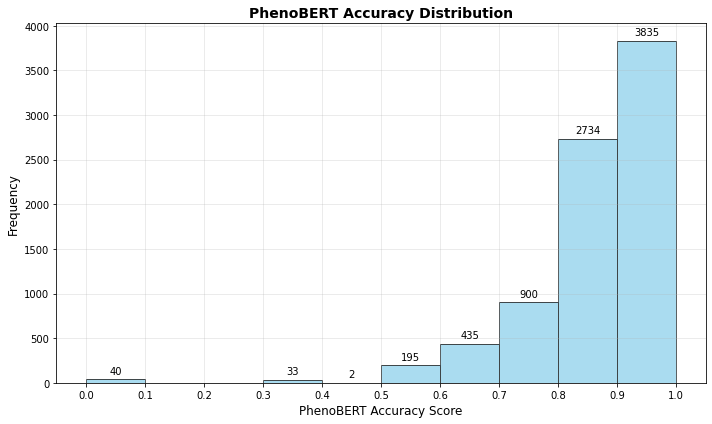

=== PhenoBERT Accuracy 統計資訊 ===
總樣本數: 8174
平均值: 0.8687
中位數: 0.8889
標準差: 0.1272
最小值: 0.0000
最大值: 1.0000

=== 各分數區間統計 ===
0.0-0.1:   40 樣本 (  0.5%)
0.1-0.2:    0 樣本 (  0.0%)
0.2-0.3:    0 樣本 (  0.0%)
0.3-0.4:   33 樣本 (  0.4%)
0.4-0.5:    2 樣本 (  0.0%)
0.5-0.6:  195 樣本 (  2.4%)
0.6-0.7:  435 樣本 (  5.3%)
0.7-0.8:  900 樣本 ( 11.0%)
0.8-0.9: 2734 樣本 ( 33.4%)
0.9-1.0: 3835 樣本 ( 46.9%)


In [54]:
plot_phenobert_accuracy_distribution(df_phenopacket)

In [58]:
df_phenopacket[df_phenopacket['phenobert_accuracy']==0.0]

,case_id,sex,age,diagnoses,hpo_terms,clinical_summary,hpo_ids,normalized_hpo_ids,phenobert_hpo_ids,normalized_phenobert_hpo_ids,phenobert_accuracy
871,PMID_38230350_Proband_P4_family_B_B_II_1,MALE,NaN,"Pulmonary hypertension, primary, 6 (OMIM:620777)",Dyspnea (HP:0002094),Clinical findings such as Breathing difficulty...,HP:0002094,HP:0002094,"HP:0005957,HP:0002092","HP:0005957,HP:0002092",0.0
2499,PMID_25802881_P53,MALE,NaN,"Osseous heteroplasia, progressive (OMIM:166350)",Subcutaneous ossification (HP:0034282),This case involves A a male diagnosed with oss...,HP:0034282,HP:0034282,-,-,0.0
2618,PMID_9398836_Family_J2_20_III_3,MALE,NaN,Renal cysts and diabetes syndrome (OMIM:137920),Maturity-onset diabetes of the young (HP:0004904),Maturity-onset diabetes of the young are obser...,HP:0004904,HP:0004904,"HP:0000819,HP:0000107","HP:0000819,HP:0000107",0.0
2780,PMID_12384777_Family_1_I_1,FEMALE,NaN,Inosine triphosphatase deficiency (OMIM:613850),Elevated erythrocyte inosine triphosphate conc...,A a female shows clinical features including e...,"HP:6000510,HP:6000511","HP:6000510,HP:6000511",-,-,0.0
2781,PMID_12384777_Family_1_II_2,NaN,NaN,Inosine triphosphatase deficiency (OMIM:613850),Elevated erythrocyte inosine triphosphate conc...,Clinical findings such as elevated erythrocyte...,"HP:6000510,HP:6000511","HP:6000510,HP:6000511",-,-,0.0
2782,PMID_12384777_Family_3_3A,NaN,NaN,Inosine triphosphatase deficiency (OMIM:613850),Elevated erythrocyte inosine triphosphate conc...,This case involves A patient diagnosed with in...,"HP:6000510,HP:6000511","HP:6000510,HP:6000511",-,-,0.0
2783,PMID_12384777_Family_4_4A,NaN,NaN,Inosine triphosphatase deficiency (OMIM:613850),Elevated erythrocyte inosine triphosphate conc...,A patient with inosine triphosphatase deficien...,"HP:6000510,HP:6000511","HP:6000510,HP:6000511",-,-,0.0
2784,PMID_12384777_Family_5_5A,NaN,NaN,Inosine triphosphatase deficiency (OMIM:613850),Elevated erythrocyte inosine triphosphate conc...,A patient shows clinical features including el...,"HP:6000510,HP:6000511","HP:6000510,HP:6000511",-,-,0.0
2785,PMID_12384777_Family_6_6A,NaN,NaN,Inosine triphosphatase deficiency (OMIM:613850),Elevated erythrocyte inosine triphosphate conc...,Clinical findings such as elevated erythrocyte...,"HP:6000510,HP:6000511","HP:6000510,HP:6000511",-,-,0.0
4750,PMID_19781681_Proband_P1_1,NaN,NaN,"Osteogenesis imperfecta, type IX (OMIM:259440)",Bowing of limbs due to multiple fractures (HP:...,"A patient with osteogenesis imperfecta, type i...","HP:0003023,HP:0005855","HP:0003023,HP:0005855","HP:0002757,HP:0006487,HP:0002757","HP:0002757,HP:0006487",0.0


In [25]:
df_phenopacket[df_phenopacket['normalized_hpo_ids'] =='HP:0034282']

,case_id,sex,age,diagnoses,hpo_terms,clinical_summary,hpo_ids,normalized_hpo_ids,phenobert_hpo_ids,normalized_phenobert_hpo_ids,phenobert_accuracy
2499,PMID_25802881_P53,MALE,NaN,"Osseous heteroplasia, progressive (OMIM:166350)",Subcutaneous ossification (HP:0034282),This case involves A a male diagnosed with oss...,HP:0034282,HP:0034282,NaN,-,0.0


In [28]:
df_phenopacket['phenobert_hpo_ids'].fillna('-')

nan

In [112]:
df_phenopacket['phenobert_hpo_ids'] = df_phenopacket['clinical_summary'].progress_apply(phenobert_predict)

  0%|          | 12/8174 [00:15<2:56:35,  1.30s/it]


KeyboardInterrupt: 

In [63]:
answer_hpo_list = sorted(term.split(' (')[1].replace(')','') for term in df_phenopacket['hpo_terms'][0].split('; '))

In [64]:
answer_hpo_list

['HP:0000078',
 'HP:0000175',
 'HP:0000179',
 'HP:0000215',
 'HP:0000218',
 'HP:0000219',
 'HP:0000232',
 'HP:0000243',
 'HP:0000269',
 'HP:0000283',
 'HP:0000286',
 'HP:0000293',
 'HP:0000294',
 'HP:0000311',
 'HP:0000316',
 'HP:0000319',
 'HP:0000322',
 'HP:0000325',
 'HP:0000337',
 'HP:0000341',
 'HP:0000343',
 'HP:0000348',
 'HP:0000358',
 'HP:0000369',
 'HP:0000405',
 'HP:0000414',
 'HP:0000431',
 'HP:0000463',
 'HP:0000465',
 'HP:0000470',
 'HP:0000490',
 'HP:0000494',
 'HP:0000508',
 'HP:0000518',
 'HP:0000520',
 'HP:0000527',
 'HP:0000574',
 'HP:0000612',
 'HP:0001083',
 'HP:0001245',
 'HP:0001537',
 'HP:0001762',
 'HP:0001763',
 'HP:0001822',
 'HP:0001847',
 'HP:0001863',
 'HP:0002002',
 'HP:0002299',
 'HP:0002553',
 'HP:0003189',
 'HP:0005278',
 'HP:0005469',
 'HP:0006482',
 'HP:0008551',
 'HP:0009765',
 'HP:0010282',
 'HP:0010487',
 'HP:0011220',
 'HP:0011304',
 'HP:0012368',
 'HP:0020045',
 'HP:0020049',
 'HP:0045075']

In [23]:
import pandas as pd
from io import StringIO

data = df_phenopacket['clinical_summary'][0]
# 讀入 DataFrame
df = pd.read_csv(StringIO(data), sep="\t", header=None)

# 根據最大欄位數設定欄位名稱
if df.shape[1] == 6:  # 有 Neg 欄位
    df.columns = ["start", "end", "term", "hpo_id", "score", "flag"]
else:
    df.columns = ["start", "end", "term", "hpo_id", "score"]

print(df.head())

ValueError: Length mismatch: Expected axis has 1 elements, new values have 5 elements

In [ ]:
def phenobert_predict(discription):
    data_string = annotate_text(discription)
    df = pd.read_csv(StringIO(data_string), sep='\t', header=None ,names=['start', 'end', 'description', 'hpo_id', 'score', 'note'])
    df = df.sort_values(by='description')
    return ','.join(list(df.hpo_id))

In [34]:
data_string = annotate_text(df_phenopacket['clinical_summary'][0])

In [40]:
df = pd.read_csv(StringIO(data_string), sep='\t', header=None ,names=['start', 'end', 'description', 'hp_code', 'score', 'note'])
df = df.sort_values(by='description')

In [101]:
df

,start,end,description,hp_code,score,note
44,993,1020,Abnormality of dental shape,HP:0006482,1.0,NaN
6,154,192,Abnormality of the reproductive system,HP:0000078,1.0,NaN
45,1022,1034,Apple cheeks,HP:0000293,1.0,NaN
3,94,109,Arched eyebrows,HP:0002553,1.0,NaN
50,1139,1151,Brittle hair,HP:0002299,1.0,NaN
13,365,375,Broad face,HP:0000283,1.0,NaN
28,656,679,Broad flat nasal bridge,HP:0000431,1.0,NaN
2,78,92,Broad forehead,HP:0000337,1.0,NaN
54,1216,1227,Broad thumb,HP:0011304,1.0,NaN
30,697,709,Bulbous nose,HP:0000414,1.0,NaN


In [43]:
output_list = []
for idx in df.index:
    output_list.append(f'{df.description[idx]} ({df.hp_code[idx]})')

In [46]:
pred_hpo = [hpo for hpo in output_list if hpo in answer_hpo_list]

In [47]:
len(pred_hpo)

9

In [48]:
len(answer_hpo_list)

63

In [49]:
len(output_list)

60

In [52]:
output_list

['Abnormality of dental shape (HP:0006482)',
 'Abnormality of the reproductive system (HP:0000078)',
 'Apple cheeks (HP:0000293)',
 'Arched eyebrows (HP:0002553)',
 'Brittle hair (HP:0002299)',
 'Broad face (HP:0000283)',
 'Broad flat nasal bridge (HP:0000431)',
 'Broad forehead (HP:0000337)',
 'Broad thumb (HP:0011304)',
 'Bulbous nose (HP:0000414)',
 'Bulging eye (HP:0000520)',
 'Bulging forehead (HP:0011220)',
 'Bunion (HP:0001822)',
 'Bushy eyebrows (HP:0000574)',
 'Cat eye (HP:0000612)',
 'Circular face (HP:0000311)',
 'Cleft palate (HP:0000175)',
 'Clouding of the lens of the eye (HP:0000518)',
 'Club feet (HP:0001762)',
 'Conductive deafness (HP:0000405)',
 'Decreased length of neck (HP:0000470)',
 'Decreased size of nasal tip (HP:0005278)',
 'Decreased volume of lower lip (HP:0010282)',
 'Decreased width of the forehead (HP:0000341)',
 'Deep set eye (HP:0000490)',
 'Downward slanting of the opening between the eyelids (HP:0000494)',
 'Drooping lower lip (HP:0000232)',
 'Droopin

In [51]:
answer_hpo_list

['Abnormal dental morphology (HP:0006482)',
 'Abnormality of the genital system (HP:0000078)',
 'Anteverted nares (HP:0000463)',
 'Brittle hair (HP:0002299)',
 'Broad face (HP:0000283)',
 'Broad forehead (HP:0000337)',
 'Broad thumb (HP:0011304)',
 'Bulbous nose (HP:0000414)',
 'Cataract (HP:0000518)',
 'Cleft palate (HP:0000175)',
 'Conductive hearing impairment (HP:0000405)',
 'Deep philtrum (HP:0002002)',
 'Deeply set eye (HP:0000490)',
 'Downslanted palpebral fissures (HP:0000494)',
 'Ectopia lentis (HP:0001083)',
 'Epicanthus (HP:0000286)',
 'Esodeviation (HP:0020045)',
 'Everted lower lip vermilion (HP:0000232)',
 'Exodeviation (HP:0020049)',
 'Flat face (HP:0012368)',
 'Flat occiput (HP:0005469)',
 'Full cheeks (HP:0000293)',
 'Hallux valgus (HP:0001822)',
 'High forehead (HP:0000348)',
 'High palate (HP:0000218)',
 'Highly arched eyebrow (HP:0002553)',
 'Hypertelorism (HP:0000316)',
 'Hypoplastic nasal tip (HP:0005278)',
 'Iris coloboma (HP:0000612)',
 'Long eyelashes (HP:00005

In [50]:
pred_hpo

['Brittle hair (HP:0002299)',
 'Broad face (HP:0000283)',
 'Broad forehead (HP:0000337)',
 'Broad thumb (HP:0011304)',
 'Bulbous nose (HP:0000414)',
 'Cleft palate (HP:0000175)',
 'Flat face (HP:0012368)',
 'High forehead (HP:0000348)',
 'Sparse eyebrow (HP:0045075)']